# **Audio Classification**

Objectives: Examine different audio files and train various models to predict and classify audio files based on their extracted features. 

> - `audio_dataset.py` contains code to download the datasets from kaggle
> - `features.py` contains code to extract features from each audio files
> - `CNN.py` contains code to build and compile the CNN model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/My Drive/project") #change the working directory to My Drive
import numpy as np
import pandas as pd
import zipfile
!pip install wget
import librosa
import shutil
import pickle
import json
import librosa.display
import scipy.io.wavfile
import IPython.display as ipd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore') # to ignore any warnings

##**1. Downloading the required dataset from the source path.**

We run the below cell to prepare the audio dataset for the project or else download and unzip the dataset into '.project/dataset' directory.

**Please note if you are working with the google drive then it takes time to reflect the changes on the drive.** 

In [0]:
audio_dataset.prepare_audio_dataset() #call the function from audio_dataset module to prepare dataset

In [0]:
#import the modules required for preprocessing and training 
from utils import audio_dataset, features
from models import CNN

##**2. Exploratory Data Analysis**




In [4]:
#read the meta data of the dataset
train = pd.read_csv('dataset/FSDKaggle2018.meta/train_post_competition.csv')
test = pd.read_csv('dataset/FSDKaggle2018.meta/test_post_competition_scoring_clips.csv') 
print("Number of training examples=", train.shape[0], "  Number of test examples =", test.shape[0],  "  Number of classes=", len(train.label.unique()))

#verify the number of audio files in each directory by matching count with the meta data files.
assert (len(os.listdir('dataset/FSDKaggle2018.audio_train')) == train.shape[0])
assert (len(os.listdir('dataset/FSDKaggle2018.audio_test')) == test.shape[0])

Number of training examples= 9473   Number of test examples = 1600   Number of classes= 41


### **Examining the sampling rate for a random audio file.** 

In [6]:
i = np.random.randint(9473) #generate random integer in the range of training examples
filename = train['fname'][i] #get the randomly indexed file name
librosa_audio, librosa_sample_rate = librosa.load('dataset/FSDKaggle2018.audio_train/' + filename)
sampling_rate, song_array = scipy.io.wavfile.read('dataset/FSDKaggle2018.audio_train/' + filename)
print("Librosa sampling rate is=", librosa_sample_rate, "  Actual sampling rate of the audio is=" , sampling_rate)

Librosa sampling rate is= 22050   Actual sampling rate of the audio is= 44100


Librosa resamples the audio file  by default to 22050 HZ while loading. If we pass the "sr=None" while loading then librosa will not resample the audio. The resampling is done mostly to lower memory consumption(source: https://librosa.github.io/blog/2019/07/17/resample-on-load/).



###**Let's listen to the audio file and see it's lable.**

In [7]:
ipd.Audio('dataset/FSDKaggle2018.audio_train/' + filename)

In [8]:
print ("Class label is:",train['label'][i] )

Class label is: Cowbell


###**Plot the audio using librosa.display**

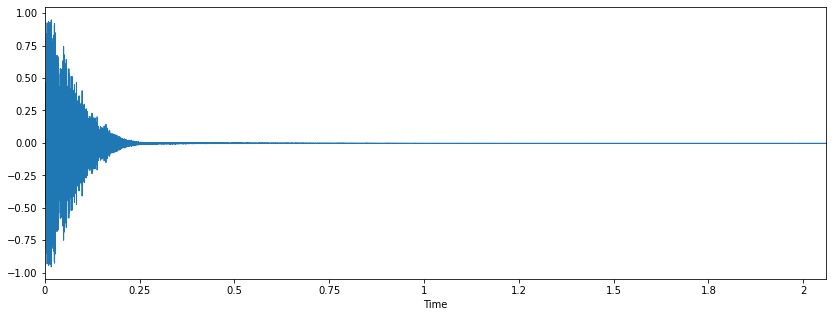

In [9]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot (librosa_audio, sr=librosa_sample_rate) #plot the audio array using librosa.display.waveplot

###**Analysing the distribution of class labels for the dataset**

Text(0, 0.5, 'Number of Samples')

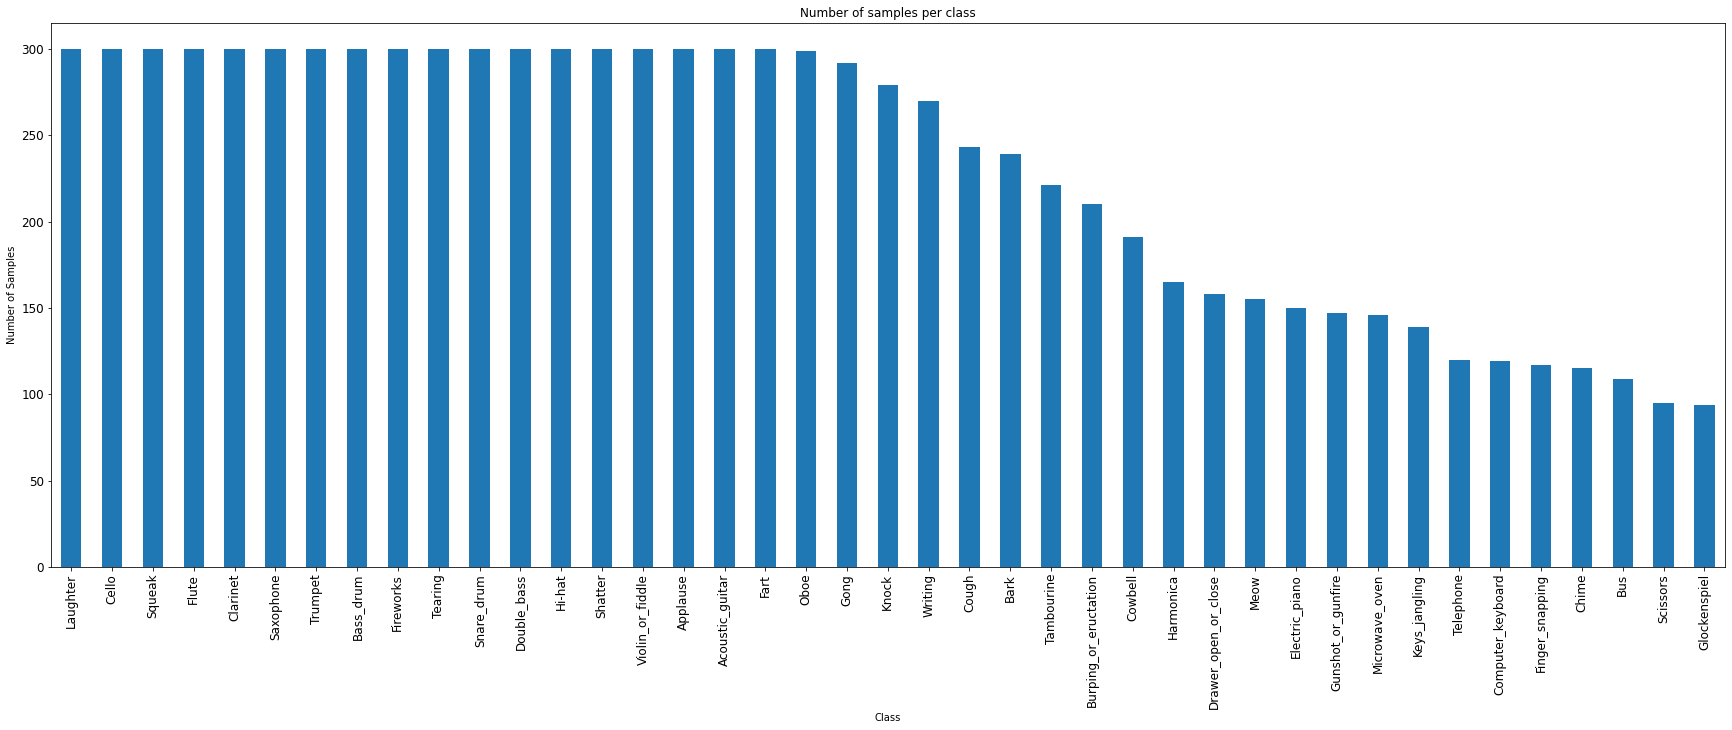

In [10]:
#plotting the distribution of the class labels 
ax= train['label'].value_counts().plot(kind='bar', title ="Number of samples per class", figsize=(30, 10), fontsize=12)
ax.set_xlabel("Class")
ax.set_ylabel("Number of Samples")

Classes are imbalanced. The number of audio samples for the training per label are not same. The minimum number of audio samples per label is 94 and the maximum number is 300.

##**3. Feature extractions from audio files.**

To extract the features we will make use of 'feature_extraction' module of the utils package.
As a part of this project, we will extract two type of features from the audio file:
1. Mel-frequency cepstral coefficients (MFCCs): MFCCs are derived from the audio clip's cepstral representation. In Mel-scale, the frequency bands are equally spaced, which are closer to the human auditory system's response than the linearly-spaced frequency bands. This is the one of the benifits of using these features to train the prediction model.
2. Log-mel features: These features are derived from the MFCCs by taking the log of the powers at each of the mel frequencies. They are widely used in audio-tagging tasks.

###**Generating and saving MFCC features:**

In [0]:
#check if features directory is present if not present then create it. 
if not os.path.exists('features'):
        os.mkdir('features')

#generate mfcc features
train_mfcc, test_mfcc = features.generate_features('mfcc')

#dump the features into pickle file for future use
with open('features/train_mfcc.pkl', 'wb') as outfile:
   pickle.dump(train_mfcc, outfile, pickle.HIGHEST_PROTOCOL)
with open('features/test_mfcc.pkl', 'wb') as outfile:
   pickle.dump(test_mfcc, outfile, pickle.HIGHEST_PROTOCOL)

###**Generating and saving Log-mel features**

In [0]:
#generate logmel features
train_logmel, test_logmel = features.generate_features('logmel')

with open('features/train_logmel.pkl', 'wb') as outfile:
   pickle.dump(train_logmel, outfile, pickle.HIGHEST_PROTOCOL)
with open('features/test_logmel.pkl', 'wb') as outfile:
   pickle.dump(test_logmel, outfile, pickle.HIGHEST_PROTOCOL)


###**Preparing the Train and Test labels using Meta data**

In [0]:
#define function to prepare the labels
def prepare_targets(Y_train, Y_test):
	le = LabelEncoder()
	le.fit(Y_train)
	Y_train = le.transform(Y_train)
	Y_test = le.transform(Y_test)
	return Y_train, Y_test

Y_train, Y_test =  prepare_targets(train['label'], test['label']) #call the function to prepare labels

#verify the shape of the lables.
assert (len(Y_train) == train.shape[0])
assert (len(Y_test) == test.shape[0])

#Save the labels into .npy files for future use
np.save('features/Y_train', Y_train)
np.save('features/Y_test', Y_test)

##**3. Building the models**

### **Logistic Regression Model**

Let's try and fit our data with the logistic regression model. We'll use scikit `sklearn` built-in functions to perform the regression.

#### **Import all the required packages**

In [0]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import scale
from sklearn.neural_network import MLPClassifier

#### **Preparing Your Dataset**

In [0]:
def prepare_data(feature_type):
    """
  This function prepares the input dataset for the logistic regression & MLP model.
  input: feature type
  output: X_train and X_test prepared for the input feature type

  """
    X_train = []
    X_test = []
    with open('features/train_'+ feature_type +'.pkl', 'rb') as infile:
      train = pickle.load(infile)
    with open('features/test_'+ feature_type +'.pkl', 'rb') as infile:
      test = pickle.load(infile)

    for i in train:
      X_train.append(np.mean(i.T,axis=0))
    X_train = np.stack(X_train)  
    
    for i in test:
      X_test.append(np.mean(i.T,axis=0))
    X_test = np.stack(X_test)
    
    #Reshape and scale both features so that features are flattened into a single vector
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)    
    X_train = scale(X_train, axis=0, with_mean=True, with_std=True, copy=False)
    X_test = scale(X_test, axis=0, with_mean=True, with_std=True, copy=False)

    #verify the shape of the dataset.
    if feature_type == 'mfcc':
      assert (X_train.shape == (9473,40))
      assert (X_test.shape == (1600,40))
    if feature_type == 'logmel':
      assert (X_train.shape == (9473,64))
      assert (X_test.shape == (1600,64))
    
    return X_train, X_test

In [0]:
#prepare MFCC data
X_train_mfcc , X_test_mfcc = prepare_data('mfcc')

#prepare logmel data
X_train_logmel , X_test_logmel = prepare_data('logmel')

#load the targets
Y_train = np.load('features/Y_train.npy',allow_pickle=True)
Y_test=  np.load('features/Y_test.npy', allow_pickle= True)

#### **Defining and training the logistic regression model on the mfcc features**

In [9]:
model = linear_model.LogisticRegressionCV(cv=3, solver='sag', max_iter=500);
model.fit(X_train_mfcc, Y_train.ravel());

# Report model performance on training and test data
Y_hat_train = model.predict(X_train_mfcc).reshape(Y_train.shape)
Y_hat_test = model.predict(X_test_mfcc).reshape(Y_test.shape)
n_train = Y_train.shape[0]
n_test = Y_test.shape[0]

train_acc =  accuracy_score(Y_train, Y_hat_train)
test_acc = accuracy_score(Y_test, Y_hat_test)  

print("Training Accuracy = {:.1f}%".format(train_acc*100))
print("Test Accuracy= {:.1f}%".format(test_acc*100))
print("F-1 Score = {:.1f}%".format(f1_score(Y_test, Y_hat_test,average='macro')*100))

Training Accuracy = 42.7%
Test Accuracy= 38.6%
F-1 Score = 33.7%


#### **Define and train Logistic regression model on the logmel features**

In [10]:
model = linear_model.LogisticRegressionCV(cv=3, solver='sag', max_iter=500);
model.fit(X_train_logmel, Y_train.ravel());

# Report model performance on training and test data
Y_hat_train = model.predict(X_train_logmel).reshape(Y_train.shape)
Y_hat_test = model.predict(X_test_logmel).reshape(Y_test.shape)
n_train = Y_train.shape[0]
n_test = Y_test.shape[0]

train_acc = accuracy_score(Y_train, Y_hat_train)
test_acc = accuracy_score(Y_test, Y_hat_test)  

print("Training Accuracy = {:.1f}%".format(train_acc*100))
print("Test Accuracy= {:.1f}%".format(test_acc*100))
print("F-1 Score = {:.1f}%".format(f1_score(Y_test, Y_hat_test,average='macro')*100))

Training Accuracy = 44.0%
Test Accuracy= 39.5%
F-1 Score = 34.2%


#### **Define and train MLP model on the mfcc features**

In [11]:
MLPclassifier = MLPClassifier(hidden_layer_sizes=(150,100,150), max_iter=300,activation = 'relu',solver='adam',random_state=1)
MLPclassifier.fit(X_train_mfcc,Y_train.ravel())

# Report model performance on training and test data
Y_hat_train = MLPclassifier.predict(X_train_mfcc).reshape(Y_train.shape)
Y_hat_test = MLPclassifier.predict(X_test_mfcc).reshape(Y_test.shape)
n_train = Y_train.shape[0]
n_test = Y_test.shape[0]

train_acc =  accuracy_score(Y_train, Y_hat_train)
test_acc = accuracy_score(Y_test, Y_hat_test)  

print("Training Accuracy = {:.1f}%".format(train_acc*100))
print("Test Accuracy= {:.1f}%".format(test_acc*100))
print("F-1 Score = {:.1f}%".format(f1_score(Y_test, Y_hat_test,average='macro')*100))

Training Accuracy = 99.8%
Test Accuracy= 54.5%
F-1 Score = 49.6%


#### **Define and train MLP model on the logmel features**

In [12]:
MLPclassifier = MLPClassifier(hidden_layer_sizes=(150,100,150), max_iter=300,activation = 'relu',solver='adam',random_state=1)
MLPclassifier.fit(X_train_logmel,Y_train.ravel())

# Report model performance on training and test data
Y_hat_train = MLPclassifier.predict(X_train_logmel).reshape(Y_train.shape)
Y_hat_test = MLPclassifier.predict(X_test_logmel).reshape(Y_test.shape)
n_train = Y_train.shape[0]
n_test = Y_test.shape[0]

train_acc =  accuracy_score(Y_train, Y_hat_train)
test_acc = accuracy_score(Y_test, Y_hat_test)  

print("Training Accuracy = {:.1f}%".format(train_acc*100))
print("Test Accuracy= {:.1f}%".format(test_acc*100))
print("F-1 Score = {:.1f}%".format(f1_score(Y_test, Y_hat_test,average='macro')*100))

Training Accuracy = 94.7%
Test Accuracy= 52.1%
F-1 Score = 46.8%


# **Convolutional Neural Network**

Let's try and fit our data with the deep CNN model. We will use Tensorflow to build the deep 5 layer CNN model. 

#### **Preparing the dataset for the 2-D Convolution model**

In [0]:
#function which will prepare data for the 2-D convolution
def prepare_data_CNN(feature_type):
  """
  This function will prepare the dataset for 2-D convolution.
  Input: feature_type, valid values(mfcc, logmel)
  output: returns X_train & X_test

  """
  with open('features/train_'+ feature_type +'.pkl', 'rb') as infile:
    X_train = np.stack(pickle.load(infile))
  with open('features/test_'+ feature_type +'.pkl', 'rb') as infile:
    X_test = np.stack(pickle.load(infile))

    #expand the dimensions so that 2-D convolution can be applied
  X_train = np.expand_dims(X_train, axis=-1)
  X_test = np.expand_dims(X_test, axis=-1)

  if feature_type == 'mfcc':
      assert (X_train.shape == (9473,40, 173, 1))
      assert (X_test.shape == (1600,40, 173, 1))
  if feature_type == 'logmel':
      assert (X_train.shape == (9473,64, 173, 1))
      assert (X_test.shape == (1600,64, 173, 1))

  return X_train, X_test

#function to plot the learning curve
def plot_learning(feature_type):
  """
  This function will be used to plot the learing curves and to save them on the disk.
  input: feature_type describing the type of feature on which model is trained.
  
  """

  if not os.path.exists('figures/' + feature_type):
        os.mkdir('figures/' + feature_type)
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('figures/' + feature_type + '/accuracy.png')
  plt.show()
  

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('figures/' + feature_type + '/loss.png')
  plt.show()
 

## **Training on the MFCC**

#### **Prepare MFCC data and targets for the CNN**

In [0]:
#prepare MFCC data
X_train_mfcc , X_test_mfcc = prepare_data_CNN('mfcc')

#load the targets
Y_train_mfcc = np.load('features/Y_train.npy',allow_pickle=True)
Y_train_mfcc = pd.get_dummies(Y_train_mfcc)
Y_train_mfcc = Y_train_mfcc.to_numpy()

Y_test=  np.load('features/Y_test.npy', allow_pickle= True)
Y_test = pd.get_dummies(Y_test)
Y_test = Y_test.to_numpy()

In [0]:
#define earlystopping on the validation loss with patience=2.
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

#### **Fitting the CNN model on the MFCC**

Epoch 1/20
134/134 [==============================] - 20s 149ms/step - loss: 3.8913 - accuracy: 0.2989 - val_loss: 4.0900 - val_accuracy: 0.2331
Epoch 2/20
134/134 [==============================] - 18s 134ms/step - loss: 3.1392 - accuracy: 0.4879 - val_loss: 3.2798 - val_accuracy: 0.4958
Epoch 3/20
134/134 [==============================] - 18s 135ms/step - loss: 2.7244 - accuracy: 0.6019 - val_loss: 2.9293 - val_accuracy: 0.5264
Epoch 4/20
134/134 [==============================] - 18s 136ms/step - loss: 2.4312 - accuracy: 0.6639 - val_loss: 2.6628 - val_accuracy: 0.5833
Epoch 5/20
134/134 [==============================] - 18s 135ms/step - loss: 2.1901 - accuracy: 0.7211 - val_loss: 2.4653 - val_accuracy: 0.6108
Epoch 6/20
134/134 [==============================] - 18s 135ms/step - loss: 1.9758 - accuracy: 0.7742 - val_loss: 2.4386 - val_accuracy: 0.6203
Epoch 7/20
134/134 [==============================] - 18s 135ms/step - loss: 1.7882 - accuracy: 0.8235 - val_loss: 2.2747 - val_ac

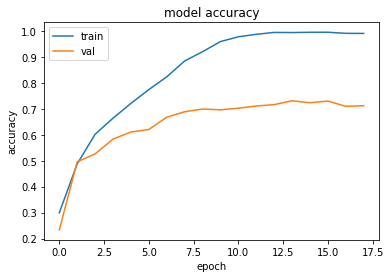

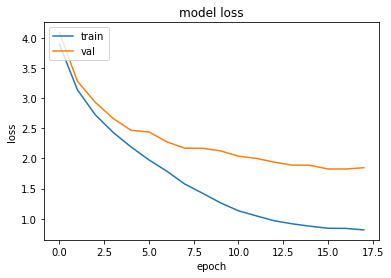

In [14]:
model= CNN.get_CNN_model(X_train_mfcc) #get the model for mfcc

history = model.fit(X_train_mfcc,Y_train_mfcc,epochs=20,validation_split=0.1, batch_size=64, callbacks=es) #train the model on the mfcc features.

#save the logs of the model
with open('logs/mfcc.json', 'w') as f:
    json.dump(history.history, f)

#save model weights
model.save_weights("weights/model_mfcc.h5")
print("Model weights saved.")

#plot the learning
plot_learning("MFCC")

From the above graph we can conclude that with the number of epochs beyond approximately 20, both, the accuracy and loss curves become flat for the validation. Therefore, a small number of epochs would be sufficient for this model with mfcc features.

#### **Evaluating the performance on the test and train data**

In [17]:
Y_train = np.load('features/Y_train.npy',allow_pickle=True)
Y_test=  np.load('features/Y_test.npy', allow_pickle= True)

Y_hat_train = model.predict_classes(X_train_mfcc, verbose=0).reshape(Y_train.shape)
Y_hat_test = model.predict_classes(X_test_mfcc, verbose=0).reshape(Y_test.shape)

train_acc =  accuracy_score(Y_train, Y_hat_train)
test_acc = accuracy_score(Y_test, Y_hat_test)  

print("Training Accuracy = {:.1f}%".format(train_acc*100))
print("Test Accuracy= {:.1f}%".format(test_acc*100))
print("F-1 Score = {:.1f}%".format(f1_score(Y_test, Y_hat_test,average='macro')*100))

Training Accuracy = 97.0%
Test Accuracy= 73.9%
F-1 Score = 73.9%


## **Training on the logmel**

#### **Prepare logmel features and targets for the CNN**

In [0]:
#prepare logmel data
X_train_logmel , X_test_logmel = prepare_data_CNN('logmel')

#load the targets
Y_train_logmel = np.load('features/Y_train.npy',allow_pickle=True)
Y_train_logmel = pd.get_dummies(Y_train_logmel)
Y_train_logmel = Y_train_logmel.to_numpy()

Y_test =  np.load('features/Y_test.npy', allow_pickle= True)
Y_test = pd.get_dummies(Y_test)
Y_test = Y_test.to_numpy()

#### **Fit the CNN model on the logmel and evaluate the performance**

Epoch 1/20
134/134 [==============================] - 25s 184ms/step - loss: 4.0296 - accuracy: 0.2857 - val_loss: 4.1047 - val_accuracy: 0.2743
Epoch 2/20
134/134 [==============================] - 22s 163ms/step - loss: 3.2189 - accuracy: 0.5032 - val_loss: 3.2241 - val_accuracy: 0.5285
Epoch 3/20
134/134 [==============================] - 22s 162ms/step - loss: 2.7891 - accuracy: 0.6093 - val_loss: 2.8757 - val_accuracy: 0.5865
Epoch 4/20
134/134 [==============================] - 22s 162ms/step - loss: 2.4526 - accuracy: 0.6981 - val_loss: 2.6449 - val_accuracy: 0.6255
Epoch 5/20
134/134 [==============================] - 22s 162ms/step - loss: 2.1960 - accuracy: 0.7588 - val_loss: 2.4822 - val_accuracy: 0.6540
Epoch 6/20
134/134 [==============================] - 22s 162ms/step - loss: 1.9867 - accuracy: 0.8095 - val_loss: 2.4615 - val_accuracy: 0.6656
Epoch 7/20
134/134 [==============================] - 22s 162ms/step - loss: 1.7832 - accuracy: 0.8657 - val_loss: 2.3543 - val_ac

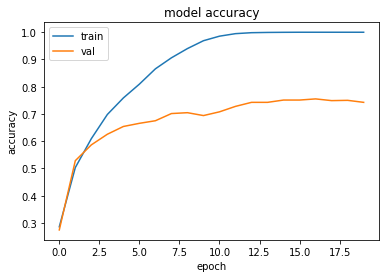

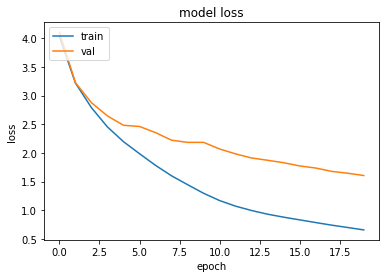

In [19]:
model= CNN.get_CNN_model(X_train_logmel) #get the model for logmel

history = model.fit(X_train_logmel,Y_train_logmel,epochs=20,validation_split=0.1, batch_size=64,callbacks=es) #train the model on the logmel features.

#save the logs of the model
with open('logs/logmel.json', 'w') as f:
    json.dump(history.history, f)

#save model weights
model.save_weights("weights/model_logmel.h5")
print("Model weights saved.")

#plot the learning
plot_learning('logmel')

In [21]:
Y_train = np.load('features/Y_train.npy',allow_pickle=True)
Y_test=  np.load('features/Y_test.npy', allow_pickle= True)

Y_hat_train = model.predict_classes(X_train_logmel, verbose=0).reshape(Y_train.shape)
Y_hat_test = model.predict_classes(X_test_logmel, verbose=0).reshape(Y_test.shape)

train_acc =  accuracy_score(Y_train, Y_hat_train)
test_acc = accuracy_score(Y_test, Y_hat_test)  

print("Training Accuracy = {:.1f}%".format(train_acc*100))
print("Test Accuracy= {:.1f}%".format(test_acc*100))
print("F-1 Score = {:.1f}%".format(f1_score(Y_test, Y_hat_test,average='macro')*100))

Training Accuracy = 97.4%
Test Accuracy= 78.8%
F-1 Score = 76.6%


## **Training on the combined features**

#### **Let's try to build the model by combining both logmel & MFCC features.**

The idea behind combining different audio features is from the paper:https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6479959/

In [0]:
#prpare MFCC data
X_train_mfcc , X_test_mfcc = prepare_data_CNN('mfcc')

#prepare logmel data
X_train_logmel , X_test_logmel = prepare_data_CNN('logmel')

#concatenate the features
X_train_combined = np.concatenate((X_train_logmel,X_train_mfcc), axis=1)
X_test_combined = np.concatenate((X_test_logmel,X_test_mfcc), axis=1)

#prepare the targets
Y_train_combined = np.load('features/Y_train.npy',allow_pickle=True)
Y_train_combined = pd.get_dummies(Y_train_combined)
Y_train_combined = Y_train_combined.to_numpy()

Y_test=  np.load('features/Y_test.npy', allow_pickle= True)
Y_test = pd.get_dummies(Y_test)
Y_test = Y_test.to_numpy()

#verify the shape of the data
assert (X_train_combined.shape == (9473,104, 173, 1))
assert (X_test_combined.shape == (1600,104, 173, 1))
assert (Y_train_combined.shape == (9473, 41))
assert (Y_test.shape == (1600, 41))

#### **Fit the CNN model on the combined features**

Epoch 1/20
134/134 [==============================] - 35s 258ms/step - loss: 4.1372 - accuracy: 0.2788 - val_loss: 4.1437 - val_accuracy: 0.2711
Epoch 2/20
134/134 [==============================] - 31s 232ms/step - loss: 3.3635 - accuracy: 0.4710 - val_loss: 3.4593 - val_accuracy: 0.4620
Epoch 3/20
134/134 [==============================] - 31s 232ms/step - loss: 2.9550 - accuracy: 0.5689 - val_loss: 3.0074 - val_accuracy: 0.5570
Epoch 4/20
134/134 [==============================] - 31s 231ms/step - loss: 2.6756 - accuracy: 0.6309 - val_loss: 2.7254 - val_accuracy: 0.6203
Epoch 5/20
134/134 [==============================] - 31s 231ms/step - loss: 2.4200 - accuracy: 0.7005 - val_loss: 2.5753 - val_accuracy: 0.6593
Epoch 6/20
134/134 [==============================] - 31s 231ms/step - loss: 2.2129 - accuracy: 0.7455 - val_loss: 2.4851 - val_accuracy: 0.6551
Epoch 7/20
134/134 [==============================] - 31s 231ms/step - loss: 2.0184 - accuracy: 0.7926 - val_loss: 2.4309 - val_ac

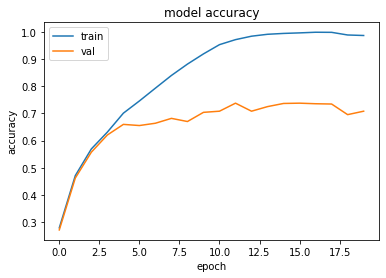

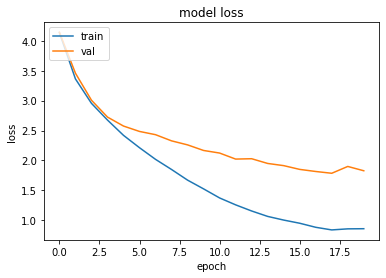

In [23]:
model= CNN.get_CNN_model(X_train_combined) #get the model for combined features

history = model.fit(X_train_combined,Y_train_combined,epochs=20,validation_split=0.1, batch_size=64, callbacks= es) #train the model on the logmel features.

#save the logs of the model
with open('logs/combined.json', 'w') as f:
    json.dump(history.history, f)

#save model weights
model.save_weights("weights/model_combined.h5")
print("Model weights saved.")

#plot and save learning curves
plot_learning('combined')

#### **Evaluating the performance on combined features** 

In [24]:
Y_train = np.load('features/Y_train.npy',allow_pickle=True)
Y_test=  np.load('features/Y_test.npy', allow_pickle= True)

Y_hat_train = model.predict_classes(X_train_combined, verbose=0).reshape(Y_train.shape)
Y_hat_test = model.predict_classes(X_test_combined, verbose=0).reshape(Y_test.shape)

train_acc =  accuracy_score(Y_train, Y_hat_train)
test_acc = accuracy_score(Y_test, Y_hat_test)  

print("Training Accuracy = {:.1f}%".format(train_acc*100))
print("Test Accuracy= {:.1f}%".format(test_acc*100))
print("F-1 Score = {:.1f}%".format(f1_score(Y_test, Y_hat_test,average='macro')*100))

Training Accuracy = 96.3%
Test Accuracy= 74.3%
F-1 Score = 71.8%


## **Let's now try to augment the data using data augmentation techniques.**

### **Augmentation for MFCC**

For the MFCC extraction with the augmented data we are augmenting the audio signal by shifting the audio to the right. The idea is from the blog:https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6

**Below cell shows the audio signal and augmented audio signal for random audio file from the training data**

Text(0.5, 1.0, 'Augmented Audio')

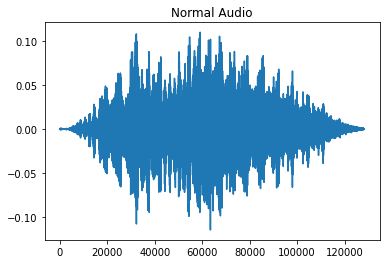

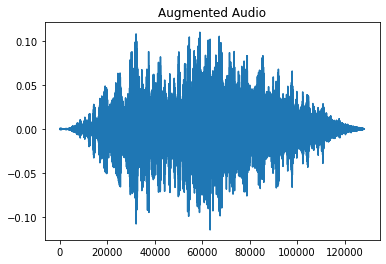

In [0]:
i = np.random.randint(9473) #generate random integer in the range of training examples
filename = train['fname'][i] #get the randomly indexed file name
librosa_audio, librosa_sample_rate = librosa.load('dataset/FSDKaggle2018.audio_train/' + filename)
augmented_audio = features.shift_audio(librosa_audio)

#plot the audio 
plt.figure()
plt.plot(librosa_audio);
plt.title('Normal Audio')

plt.figure()
plt.plot(augmented_audio);
plt.title('Augmented Audio')

## **Generate MFCC features along with augmented data and collect labels**

In [0]:
#call the method to generate augmented features. Method returns two lists containing train augmented features and train labels. 
train_mfcc_aug, train_mfcc_label_aug = features.generate_augmented_features('mfcc')

with open('features/train_mfcc_aug.pkl', 'wb') as outfile:
  pickle.dump(train_mfcc_aug, outfile, pickle.HIGHEST_PROTOCOL)

with open('features/train_mfcc_label_aug.pkl', 'wb') as outfile:
  pickle.dump(train_mfcc_label_aug, outfile, pickle.HIGHEST_PROTOCOL)

### **Augmentation for the logmel**

To augment the logmel features, we are using SpecAugment method, a simple data augmentation method for speech recognition presented in the paper: https://arxiv.org/abs/1904.08779 . The method which implements this augmentation technique is taken from the kaggle notebook https://www.kaggle.com/davids1992/specaugment-quick-implementation.

**Below cell shows the sample spectrogram of logmel and augmented logmel features of the random sample audio file**


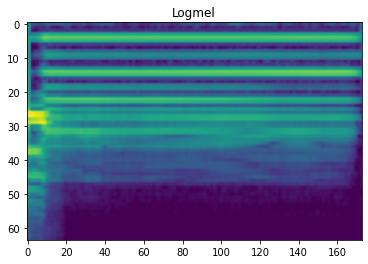

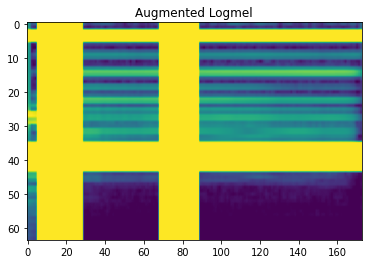

In [0]:
i = np.random.randint(9473) #generate random integer in the range of training examples
filename = train['fname'][i] #get the randomly indexed file name
librosa_audio, librosa_sample_rate = librosa.load('dataset/FSDKaggle2018.audio_train/' + filename)
logmel = features.extract_logmel(librosa_audio)
augmented_logmel = features.spec_augment(logmel)

#plot the spectrogram images
plt.figure()
plt.imshow(logmel,aspect= 'auto')
plt.title('Logmel')
plt.show()

plt.figure()
plt.imshow(augmented_logmel,aspect= 'auto')
plt.title('Augmented Logmel')
plt.show()


## **Generate logmel features along with augmented data and collect labels**

In [0]:
#call the method to generate augmented features. Method returns two lists containing train augmented features and train labels. 
train_logmel_aug, train_logmel_label_aug = features.generate_augmented_features('logmel') 

with open('features/train_logmel_aug.pkl', 'wb') as outfile:
  pickle.dump(train_logmel_aug, outfile, pickle.HIGHEST_PROTOCOL)

with open('features/train_logmel_label_aug.pkl', 'wb') as outfile:
  pickle.dump(train_logmel_label_aug, outfile, pickle.HIGHEST_PROTOCOL)

## **Prepare and save labels of augmented data for future use**

In [0]:
#read the list of labels
with open('features/train_mfcc_label_aug.pkl', 'rb') as infile:
  train_mfcc_label_aug = pickle.load(infile)
with open('features/train_logmel_label_aug.pkl', 'rb') as infile:
  train_logmel_label_aug = pickle.load(infile)

Y_train_mfcc_aug, Y_test =  prepare_targets(train_mfcc_label_aug, test['label'])
Y_train_logmel_aug, Y_test =  prepare_targets(train_logmel_label_aug, test['label'])

#Save the labels into .npy files for future use
np.save('features/train_mfcc_label_aug', Y_train_mfcc_aug)
np.save('features/train_logmel_label_aug', Y_train_logmel_aug)

## **Training on the MFCC augmented features**

**Prepare MFCC features of augmented data to train the CNN model**

In [0]:
#get the test data, test data will be same as that of previous.
_, X_test_mfcc = prepare_data_CNN('mfcc') 

# prepare training data
with open('features/train_mfcc_aug.pkl', 'rb') as infile:
  X_train_mfcc_aug = np.stack(pickle.load(infile))

X_train_mfcc_aug = np.expand_dims(X_train_mfcc_aug, axis=-1)

#load the targets
Y_train_mfcc_aug = np.load('features/train_mfcc_label_aug.npy',allow_pickle=True)
Y_train_mfcc_aug = pd.get_dummies(Y_train_mfcc_aug)
Y_train_mfcc_aug = Y_train_mfcc_aug.to_numpy()

Y_test =  np.load('features/Y_test.npy', allow_pickle= True)
Y_test = pd.get_dummies(Y_test)
Y_test = Y_test.to_numpy()

# verify the input shapes
assert (X_train_mfcc_aug.shape == (18946,40, 173, 1))
assert (X_test_mfcc.shape == (1600,40, 173, 1))

# verify the target shapes
assert (Y_train_mfcc_aug.shape == (18946,41))
assert (Y_test.shape == (1600, 41))

**Train the CNN model using MFCC augmented features and evaluate the performance.**

Epoch 1/25
267/267 [==============================] - 39s 145ms/step - loss: 3.7583 - accuracy: 0.3241 - val_loss: 3.5634 - val_accuracy: 0.3937
Epoch 2/25
267/267 [==============================] - 36s 136ms/step - loss: 3.0056 - accuracy: 0.5006 - val_loss: 3.1390 - val_accuracy: 0.4454
Epoch 3/25
267/267 [==============================] - 36s 136ms/step - loss: 2.6329 - accuracy: 0.5827 - val_loss: 2.7874 - val_accuracy: 0.5367
Epoch 4/25
267/267 [==============================] - 36s 136ms/step - loss: 2.3487 - accuracy: 0.6435 - val_loss: 2.5954 - val_accuracy: 0.5736
Epoch 5/25
267/267 [==============================] - 36s 136ms/step - loss: 2.1176 - accuracy: 0.6994 - val_loss: 2.5299 - val_accuracy: 0.5873
Epoch 6/25
267/267 [==============================] - 36s 136ms/step - loss: 1.9020 - accuracy: 0.7512 - val_loss: 2.4229 - val_accuracy: 0.5847
Epoch 7/25
267/267 [==============================] - 36s 136ms/step - loss: 1.7336 - accuracy: 0.7875 - val_loss: 2.3236 - val_ac

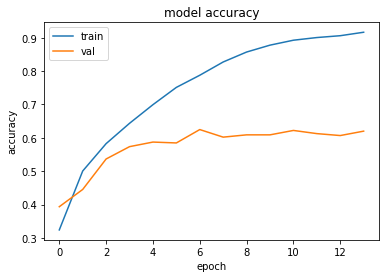

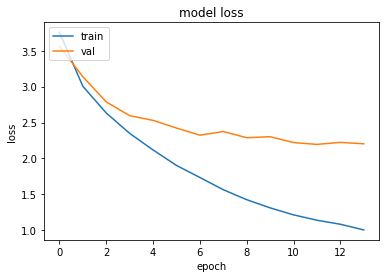

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Training Accuracy = 88.5%
Test Accuracy= 73.9%
F-1 Score = 70.6%


In [11]:
model= CNN.get_CNN_model(X_train_mfcc_aug) #get the model for mfcc_aug

history = model.fit(X_train_mfcc_aug,Y_train_mfcc_aug,epochs=25,validation_split=0.1, batch_size=64, callbacks=es) #train the model on the logmel features.

#save the logs of the model
with open('logs/mfcc_aug.json', 'w') as f:
  json.dump(history.history, f)

#save model weights
model.save_weights("weights/model_mfcc_aug.h5")
print("Model weights saved.")

#plot the learning
plot_learning("MFCC_aug")

#evaluate the performance
Y_train_aug = np.load('features/train_mfcc_label_aug.npy',allow_pickle=True)
Y_test=  np.load('features/Y_test.npy', allow_pickle= True)
Y_hat_train_aug = model.predict_classes(X_train_mfcc_aug, verbose=0).reshape(Y_train_aug.shape)
Y_hat_test = model.predict_classes(X_test_mfcc, verbose=0).reshape(Y_test.shape)

train_acc =  accuracy_score(Y_train_aug, Y_hat_train_aug)
test_acc = accuracy_score(Y_test, Y_hat_test)  

print("Training Accuracy = {:.1f}%".format(train_acc*100))
print("Test Accuracy= {:.1f}%".format(test_acc*100))
print("F-1 Score = {:.1f}%".format(f1_score(Y_test, Y_hat_test,average='macro')*100))

## **Training on the augumented logemel features**
**Prepare logmel features of augmented data to train the CNN model**

In [0]:
#get the test data, test data will be same as that of previous.
_, X_test_logmel = prepare_data_CNN('logmel') 

# prepare training data
with open('features/train_logmel_aug.pkl', 'rb') as infile:
  X_train_logmel_aug = np.stack(pickle.load(infile))

X_train_logmel_aug = np.expand_dims(X_train_logmel_aug, axis=-1)

#load the targets
Y_train_logmel_aug = np.load('features/train_logmel_label_aug.npy',allow_pickle=True)
Y_train_logmel_aug = pd.get_dummies(Y_train_logmel_aug)
Y_train_logmel_aug = Y_train_logmel_aug.to_numpy()

Y_test=  np.load('features/Y_test.npy', allow_pickle= True)
Y_test = pd.get_dummies(Y_test)
Y_test = Y_test.to_numpy()

# verify the input shapes
assert (X_train_logmel_aug.shape == (18946,64, 173, 1))
assert (X_test_logmel.shape == (1600,64, 173, 1))

# verify the target shapes
assert (Y_train_logmel_aug.shape == (18946,41))
assert (Y_test.shape == (1600, 41))

**Train the CNN model using logmel augmented features and evaluate the performance.**

Epoch 1/25
267/267 [==============================] - 47s 176ms/step - loss: 4.2069 - accuracy: 0.2159 - val_loss: 3.8642 - val_accuracy: 0.2865
Epoch 2/25
267/267 [==============================] - 44s 164ms/step - loss: 3.4310 - accuracy: 0.4042 - val_loss: 3.5109 - val_accuracy: 0.3789
Epoch 3/25
267/267 [==============================] - 44s 164ms/step - loss: 2.9393 - accuracy: 0.5241 - val_loss: 2.9715 - val_accuracy: 0.4918
Epoch 4/25
267/267 [==============================] - 44s 164ms/step - loss: 2.5632 - accuracy: 0.6185 - val_loss: 2.8152 - val_accuracy: 0.5288
Epoch 5/25
267/267 [==============================] - 44s 164ms/step - loss: 2.2420 - accuracy: 0.7015 - val_loss: 2.6826 - val_accuracy: 0.5425
Epoch 6/25
267/267 [==============================] - 44s 164ms/step - loss: 1.9528 - accuracy: 0.7750 - val_loss: 2.4531 - val_accuracy: 0.5995
Epoch 7/25
267/267 [==============================] - 44s 164ms/step - loss: 1.6892 - accuracy: 0.8442 - val_loss: 2.3793 - val_ac

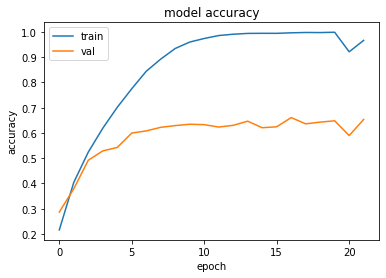

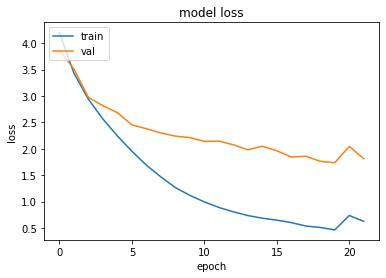

Training Accuracy = 96.2%
Test Accuracy= 74.0%
F-1 Score = 70.7%


In [13]:
model= CNN.get_CNN_model(X_train_logmel_aug) #get the model for logmel_aug

history = model.fit(X_train_logmel_aug,Y_train_logmel_aug,epochs=25,validation_split=0.1, batch_size=64,callbacks=es) #train the model on the logmel features.

#save the logs of the model
with open('logs/logmel_aug.json', 'w') as f:
    json.dump(history.history, f)

#save model weights
model.save_weights("weights/model_logmel_aug.h5")
print("Model weights saved.")

#plot the learning
plot_learning("logmel_aug")

#evaluate the performance
Y_train_aug = np.load('features/train_logmel_label_aug.npy',allow_pickle=True)
Y_test=  np.load('features/Y_test.npy', allow_pickle= True)
Y_hat_train_aug = model.predict_classes(X_train_logmel_aug, verbose=0).reshape(Y_train_aug.shape)
Y_hat_test = model.predict_classes(X_test_logmel, verbose=0).reshape(Y_test.shape)

train_acc =  accuracy_score(Y_train_aug, Y_hat_train_aug)
test_acc = accuracy_score(Y_test, Y_hat_test)  

print("Training Accuracy = {:.1f}%".format(train_acc*100))
print("Test Accuracy= {:.1f}%".format(test_acc*100))
print("F-1 Score = {:.1f}%".format(f1_score(Y_test, Y_hat_test,average='macro')*100))

## **Conclusion:**

LogMEL feature trained CNN model gave us better results than MFCC trained model as this data-set
does not contain any human voice.
LogMEL features with Convolution layers helped to classify the audio labels reasonably well even
with shallow neural networks. It also helped us to learn about the deep learning model general
behaviour to generalization for new data. So with more added noise labels, even the better tuned
hyper parameters and optimization technique did not make a big difference and will most likely
struck in the local optimum for test data, which can be rectified either with deep neural networks
or with pruned training data and better audio prepossessing techniques 